In [32]:
using Pkg
using LinearAlgebra
using SparseArrays

Pkg.add("Statistics")
using Statistics
mean
Pkg.add("Plots")
using Plots
Pkg.add("BenchmarkTools")
using BenchmarkTools

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 % Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


(typeof(k1), typeof(k2), typeof(k3)) = (Float16, Float32, Float64)
(typeof(k1), typeof(k2), typeof(k3)) = (Float16, Float32, Float64)
(typeof(k1), typeof(k2), typeof(k3)) = (Float16, Float32, Float64)
(typeof(k1), typeof(k2), typeof(k3)) = (Float16, Float32, Float64)
(typeof(k1), typeof(k2), typeof(k3)) = (Float16, Float32, Float64)


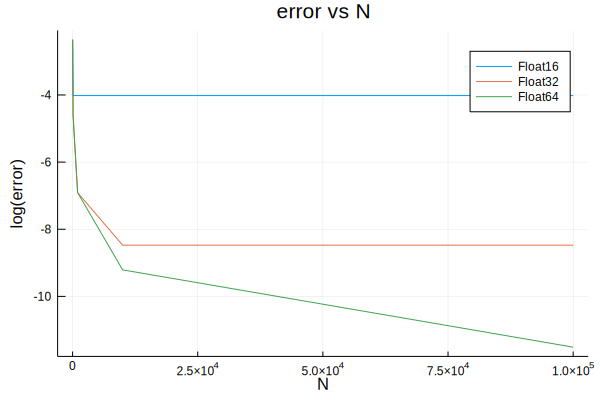

In [53]:
n_list=[10,100,1000,10000,100000]
errors_suma=zeros(3,5)

for (i,k) in enumerate(n_list)
    k1=0
    k2=0
    k3=0
    for j in collect(1:k)
        k1=k1+Float16(j^-2)
        k2=k2+Float32(j^-2)
        k3=k3+Float64(j^-2)
    end
    errors_suma[1,i]=abs(k1-pi^2/6)
    errors_suma[2,i]=abs(k2-pi^2/6)
    errors_suma[3,i]=abs(k3-pi^2/6)
    @show typeof(k1),typeof(k2),typeof(k3)
end

plot(n_list,transpose(log.(errors_suma)),
    title="error vs N",
    label=["Float16","Float32","Float64"])
xlabel!("N")
ylabel!("log(error)")


In [ ]:
"""
When using Float16 or Float32, the rounding error at every addition step prevents the
sum from achieving a lower error, which is why we see the error plots stagnating around
a fixed value after a number of iterations. 

In the case of Float64 there seems to be enugh precision as to be able to keep getting
close to the limit of pi^2/6.

Nevertheless, there might be more suitable reformulations of the sum suited for
numerical computation.
"""

 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
N = 9
errors[1, (k - k_init) + 1] = 0.05642361111111106
errors[2, (k - k_init) + 1] = 0.056423611111111084
errors[3, (k - k_init) + 1] = 0.05642361111111108
errors[4, (k - k_init) + 1] = 0.056423611111111084
errors[5, (k - k_init) + 1] = 0.056423611111111084
nonzeroratio = nonzerocounter / (N * N) = 1.0
N = 17
errors[1, (k - k_init) + 1] = 0.02952665441176818
errors[2, (k - k_init) + 1] = 0.029526654411768154
errors[3, (k - k_init) + 1] = 0.02952665441176591
errors[4, (k - k_init) + 1] = 0.0295266

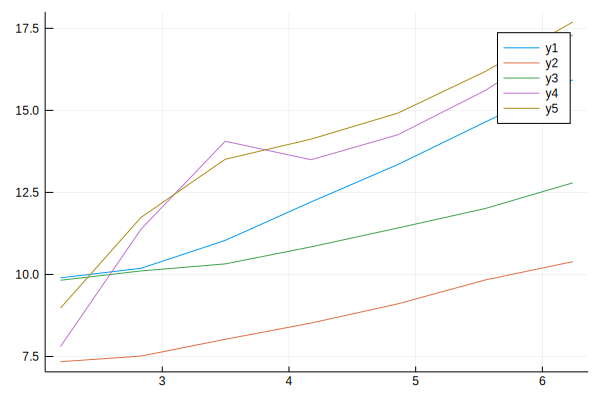

In [53]:
function make_matrix(N,alpha_thermal)
    h=1/(N-1)
    dl = -1/h*ones(N-1);
    du = -1/h*ones(N-1);
    d = 1/h*2*ones(N);

    d[1]=1/h+alpha_thermal
    d[N]=1/h+alpha_thermal
    A=Tridiagonal(dl, d, du)
    return A
end

function Progonka(A,f)
    N=length(f)
    u=zeros(N)
    a=[0;diag(A[2:end,1:end-1])]
    b=diag(A)
    c=diag(A[1:end-1,2:end])
    alpha=zeros(N)
    beta=zeros(N)

    alpha[2]=-c[1]/b[1]
    beta[2]=f[1]/b[1]

    for i in 2:N-1
        alpha[i+1]=-c[i]/(a[i]*alpha[i]+b[i])
        beta[i+1]=(f[i]-a[i]*beta[i])/(a[i]*alpha[i]+b[i])
    end
    u[N]=(f[N]-a[N]*beta[N])/(a[N]*alpha[N]+b[N])
    for i in N-1:-1:1
        u[i]=alpha[i+1]*u[i+1]+beta[i+1]
    end
    return u
end

k_init=6

k_final=14
iterations=k_final-k_init+1
N_list=exp2.(collect(k_init:k_final)).+1

global errors=zeros(5,iterations)
global times=zeros(5,iterations)

global alpha_thermal=1
global v_l=0
global v_r=0

for k in k_init:k_final
    N=2^k+1
    @show N
    h=1/(N-1)
    u_real=-h^2/2*collect(1:N).*collect(1:N) .+ h/2*collect(1:N) .+ 1/(2*alpha_thermal)
    f=h*ones(N)
    f[1]=alpha_thermal*v_l
    f[N]=alpha_thermal*v_r

    A=make_matrix(N,alpha_thermal)

    errors[1,k-k_init+1]=norm(u_real-Progonka(A,f),1)/N
    @show errors[1,k-k_init+1]
    t=@benchmark Progonka($A,$f)
    times[1,k-k_init+1]=mean(t).time

    errors[2,k-k_init+1]=norm(u_real-A\f,1)/N
    @show errors[2,k-k_init+1]
    t=@benchmark $A\$f
    times[2,k-k_init+1]=mean(t).time

    A=sparse(A)
    errors[3,k-k_init+1]=norm(u_real-A\f,1)/N
    @show errors[3,k-k_init+1]
    t=@benchmark $A\$f
    times[3,k-k_init+1]=mean(t).time

    try
        A=Matrix(A)
        errors[4,k-k_init+1]=norm(u_real-A\f,1)/N
        @show errors[4,k-k_init+1]
        t=@benchmark $A\$f
        times[4,k-k_init+1]=mean(t).time

        A_inv=inv(A)
        errors[5,k-k_init+1]=norm(u_real-A_inv*f,1)/N
        @show errors[5,k-k_init+1]
        t=@benchmark inv($A)*$f
        times[5,k-k_init+1]=mean(t).time      

        nonzerocounter = 0;
        for i = 1:N
            for j = 1:N
                if A_inv[i,j] != 0
                    nonzerocounter = nonzerocounter + 1;
                end
            end
        end
        @show nonzeroratio=nonzerocounter/(N*N)
    catch e
           println("N too big for full matrix")
    end
end

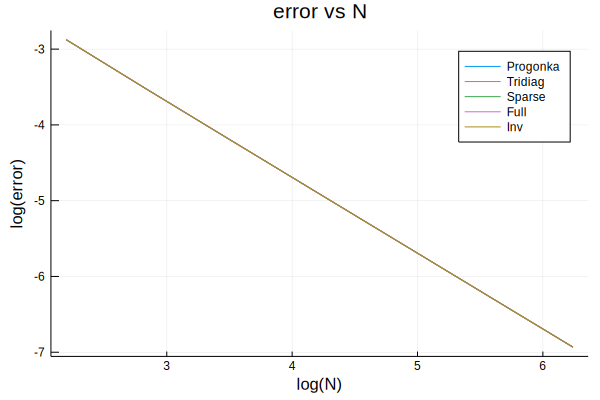

In [74]:
plot(log.(N_list),log.(transpose(errors)),
    title="error vs N",
    label=["Progonka","Tridiag","Sparse","Full","Inv"])
xlabel!("log(N)")
ylabel!("log(error)")


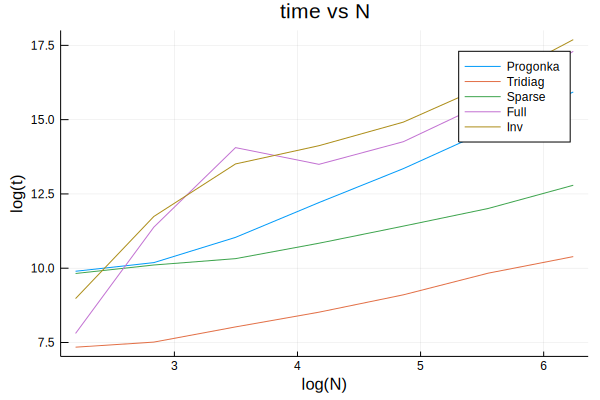

In [63]:
plot(log.(N_list),log.(transpose(times)),
    title="time vs N",
    label=["Progonka","Tridiag","Sparse","Full","Inv"])
xlabel!("log(N)")
ylabel!("log(t)")

In [75]:
"""
The limit of the analytical solution u_real as alpha goes to infinity shifts the y-intercept
from 1/2 for a=1 to 0.

All methods show similar errors that decrease with approximately order 1 as can be seen
from the first plot. 

The fastest method ist the Tridiagonal factorization method provided by Julia's standard
library. Sparse matrix methods can optimize for zero entries, but lack the information
about the exact number of nonzero entries and their position to make it as fast as
Tridiagonal methods.

Full and inverse methonds might be faster for small N, but grow faster as they
don't make use of A's sparsity.

While the Progonka method makes use of the fact that the matrix is tridiagonal, it may
not be state of the art and optimized compared to newer techniques.

As seen in the output above, the nonzero ratio of the inverse matrix is 1.0, meaning
that none of the entries of the inverse matrix are zero, which explains why matrix
inversion is not a good method for solving the system compared to the other ones.
Even if matrix A is full, it's still faster to compute the LU factorization than
inverting the matrix, as can be seen in the graph.


"""

"All methods show similar errors that decrease with approximately order 1 as can be seen\nfrom the first plot. \n\nThe fastest method ist the Tridiagonal factorization method provided by Julia's standard\nlibrary. Sparse matrix methods can optimize for zero entries, but lack the information\nabout the exact number of nonzero entries and their position to make it as fast as\nTridiagonal methods.\n\nFull and inverse methonds might be faster for small N, but grow faster as they\ndon't make use of A's sparsity.\n\nWhile the Progonka method makes use of the fact that the matrix is tridiagonal, it may\nnot be state of the art and optimized compared to newer techniques.\n\nAs seen in the output above, the nonzero ratio of the inverse matrix is 1.0, meaning\nthat none of the entries of the inverse matrix are zero, which explains why matrix\ninversion is not a good method for solving the system compared to the other ones.\nEven if matrix A is full, it's still faster to compute the LU factorizat